<a href="https://colab.research.google.com/github/yukiya06/UsedCar_Values/blob/main/pjt3_usedcar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJT3. 데이터 수집 및 전처리, ML 모델링
* 수집된 데이터 가공 및 간단한 분석작업 선행 
* 이후 데이터→**DB적재**, 시각화→**대시보드** 에서 진행

In [ ]:
#!pip install category_encoders

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
%matplotlib inline

import re
import time
import missingno as msno
import statsmodels.api as sm
import requests

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from category_encoders import OrdinalEncoder, TargetEncoder
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

#1. 캐글 데이터에서 중고차 VIN, 자동차 특성 추출
* https://www.kaggle.com/austinreese/craigslist-carstrucks-data
* Craigslist(크레이그리스트) https://craigslist.org/ : 중고 매물, 구인 구직, 주택, 자유 주제 토론등을 다루는 커뮤니티 웹사이트
* 미국내 중고차 매물 **약 51만 건** 스크레이핑 자료
* 결측치, 중복데이터 제거 후 **약 7만 건** 사용 
* 핵심정보 (주행거리, 등록번호 등) 이 누락된 정보가 많고, 다른 데이터로 대체 불가능하므로 제외하고 진행

In [ ]:
# 캐글 데이터
df = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/pjt3/vehicles_old.csv')

결측치 시각화

In [ ]:
def columns_na_percentage(df,columns):
    for column in columns:
        percentage = round(100 -(len(df['{}'.format(column)].dropna()) / len(df)) * 100,2)
        if percentage :
            print("{} : ".format(column), percentage,"%",end='\n')

            
columns_na_percentage(df ,df.columns)

year :  0.3 %
manufacturer :  4.47 %
model :  1.57 %
condition :  45.52 %
cylinders :  39.19 %
fuel :  0.78 %
odometer :  18.12 %
title_status :  0.6 %
transmission :  0.73 %
vin :  40.71 %
drive :  28.29 %
size :  67.12 %
type :  27.77 %
paint_color :  32.32 %
county :  100.0 %
lat :  2.02 %
long :  2.02 %


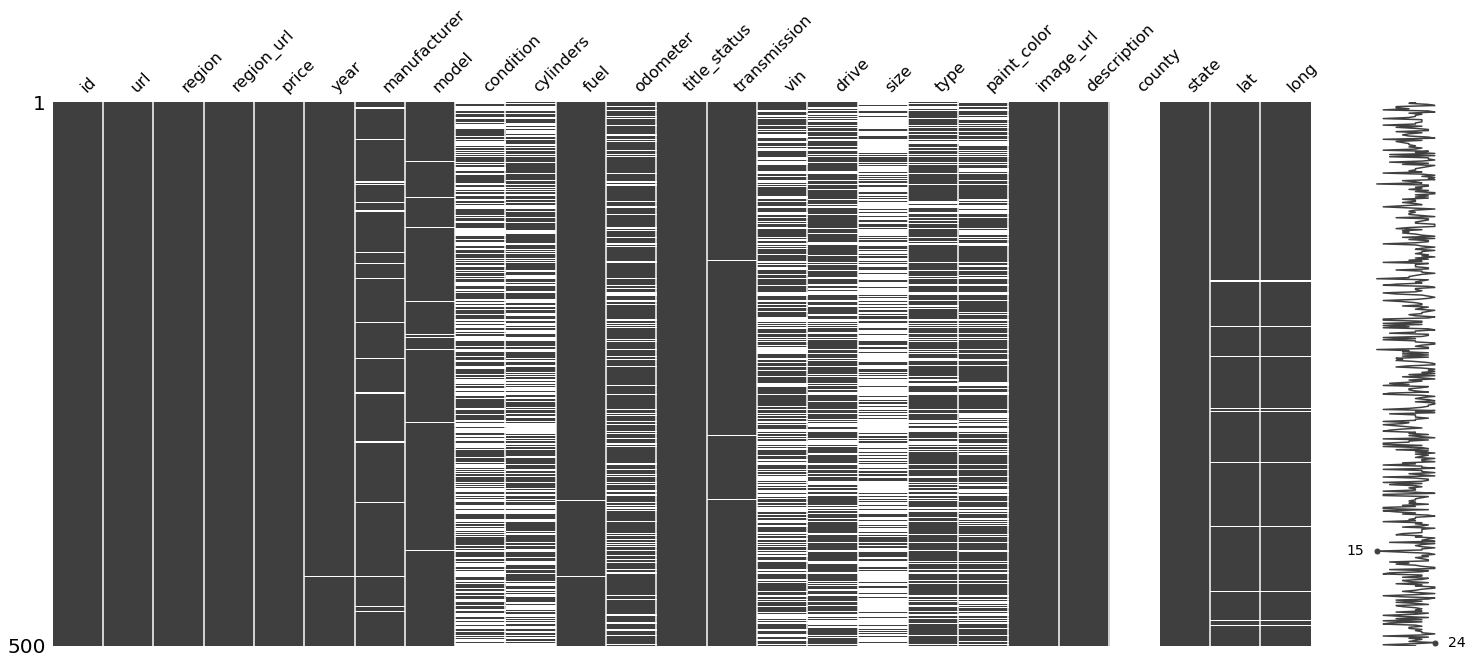

In [ ]:
msno.matrix(df.sample(500));

컬럼명	설명
* region 지역
* price 중고차 가격
* year 중고차 연식
* manufacturer 제조사
* cylinder 엔진 기통수
* fuel	연료타입
* odometer	총주행거리
* title_status	차량 상태
* transmission	미션
* VIN	차대번호
* drive	구동방식
* size 차량크기
* type 차량 타입
* paint_color 차량 색상
* state	주
* model 차량 모델명

#2. VIN API 교차 검증
* 스크레이핑 자료에 결측치가 너무 많고 가격 및 운행정보에 대한 신뢰성이 낮음
* 중고 매물사이트의 자료에서 유효한 VIN 번호 추출
* Vehicle Identification Number(VIN)를 활용한 자동차 정보 조회(API)를 통해 데이터 필터링 후 사용
* vinaudit.com이 제공하는 API에서 VIN 자료를 스크레이핑하여 통합하여 사용

참고 (vinaudit.com이 제공하는 API 가 사용하는 데이터 출처)
* 자동차 이력 제공시스템 : (NMVTIS/National Motor Vehicle Title Information System)
* 미국 도로교통 안전국 : (NHTSA / National Highway Traffic Safety Administration)
* 미국 교통부 연방차량안전국 : (Federal Motor Carrier Safety Administration, FMCSA)
* 그외 미국 정부 기관과 관련된 업체 및 파트너사

API 스크레이핑
* 대용량 자료 추출시(필요자료: 7만 건) 오류가 많이 나서 일정단위(1천~)로 끊어서 진행
* 나눠서 csv로 추출 후 합쳐서 사용

In [ ]:
%time
start_num = 1001
end_num = 2000
result_list2 = []
result = {}
# [start_num:end_num]에 숫자 업데이트
for i in df.sort_values(by=['odometer'],ascending=False)[['vin','odometer','price']][start_num:end_num].iterrows():
    vin = i[1][0]
    odometer = i[1][1]
    url = 'https://marketvalue.vinaudit.com/getmarketvalue.php?key=1HB7ICF9L0GVH5Q&vin={}&mileage={}&country=USA'.format(vin, odometer)
    response = requests.get(url)
    jsonresponse = response.json()
    for k, v in jsonresponse.items():
        if k == 'prices':
            for key, value in v.items():
                result[key] = value
        else:
            result[k] = v

    result_list2.append(result)
    result = {}

In [ ]:
# 나눠서 수집후 csv로 추출, 합쳐서 사용 
df29 = pd.DataFrame(result_list29)
vin_c4 = pd.concat([df24,df25,df26,df27,df28,df29],axis=0)
vin_c4.to_csv('/content/drive/MyDrive/AI09_Pjt/pjt3/vin_c4.csv')
vin_c = pd.concat([vin_c1,vin_c2, vin_c3, vin_c4],axis=0)
vin_c.to_csv('/content/drive/MyDrive/AI09_Pjt/pjt3/vin_c.csv')

In [ ]:
vin_c = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/pjt3/vin_c.csv')

API에서 검증된 자료만 사용, 가격정보를 API 기준으로 업데이트

In [ ]:
vin_c['success'].value_counts()

True     74529
False     2781
Name: success, dtype: int64

# 3. 최종 데이터 완성
* 캐글+API 데이터 merge하여 오탈차, outlier 검증후 제외
* 최종 데이터 완성
* 머신러닝 적용시 문제가 될 만한 컬럼은 삭제하고 모델에 적용
* 가격은 average만 사용 (below, above 삭제)
* 데이터의 누적으로 생긴 항목도 제외 (stdev, count, certainty)

In [ ]:
df_f = pd.read_csv('/content/drive/MyDrive/AI09_Pjt/pjt3/df_cars.csv', index_col='Unnamed: 0')

In [ ]:
df_f.shape

(73958, 14)

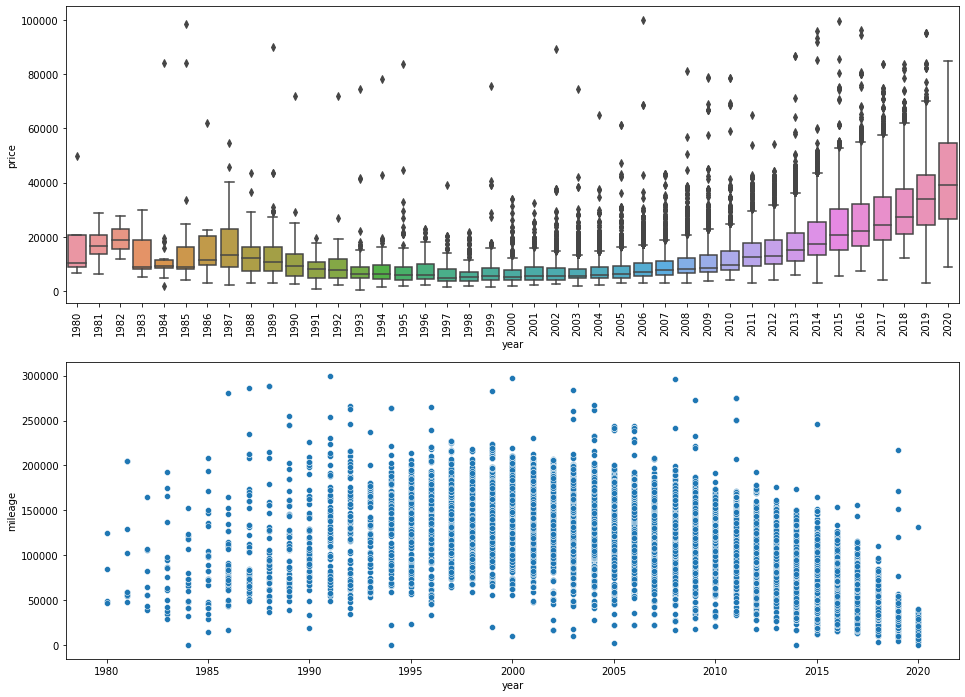

In [ ]:
plt.figure(figsize=(16,12))

plt.subplot(211)
sns.boxplot(x="year", y="price", data = df_f);
plt.xticks(rotation=90)

plt.subplot(212)
sns.scatterplot(df_f['year'],df_f['mileage']);

plt.show()

#4. 변수탐색
* 종속변수 - 가격 (average)
 * **회귀분석(target:가격)** : 타겟 분포가 비대칭 형태인지 확인, 정규분포에서 좋은 성능
 * 타겟이 right-skewed 상태 : 로그변환 사용, 비대칭 분포형태를 정규분포형태로 변환

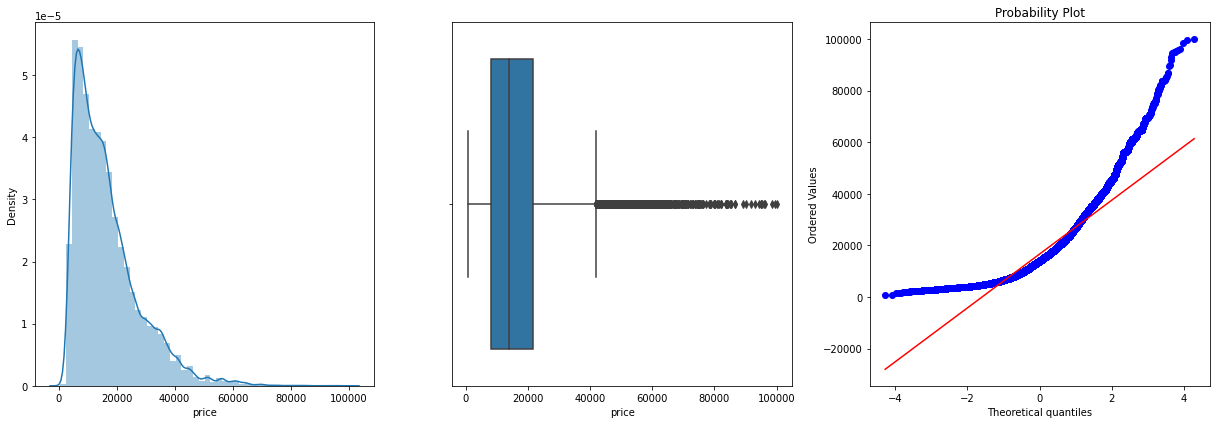

In [ ]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(df_f['price']);

plt.subplot(132)
sns.boxplot(df_f['price']);

plt.subplot(133)
stats.probplot(df_f['price'],plot=plt);
plt.tight_layout()
plt.show()

* log1p: ln(1 + x)
* expm1: exp(x) - 1, the inverse of log1p.
 * sns.distplot(np.expm1(np.log1p(df_f['price'])));

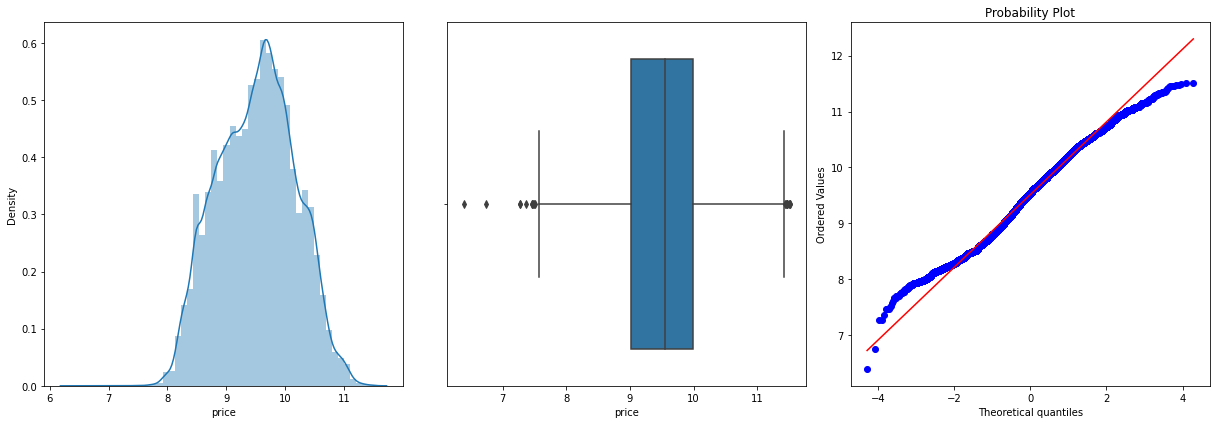

In [ ]:
plt.figure(figsize=(17,6))

plt.subplot(131)
sns.distplot(np.log1p(df_f['price']))

plt.subplot(132)
sns.boxplot(np.log1p(df_f['price']))

plt.subplot(133)
stats.probplot(np.log1p(df_f['price']),plot=plt)
plt.tight_layout()
plt.show()

* 독립변수 - 연식(year)

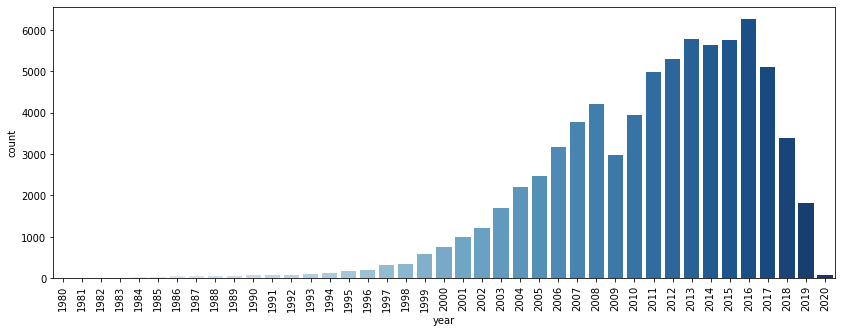

In [ ]:
plt.figure(figsize=(14,5))
sns.countplot(data=df_f, x='year', palette="Blues")
plt.xticks(rotation=90)
plt.show()

* 독립변수 - 주행거리(mileage)

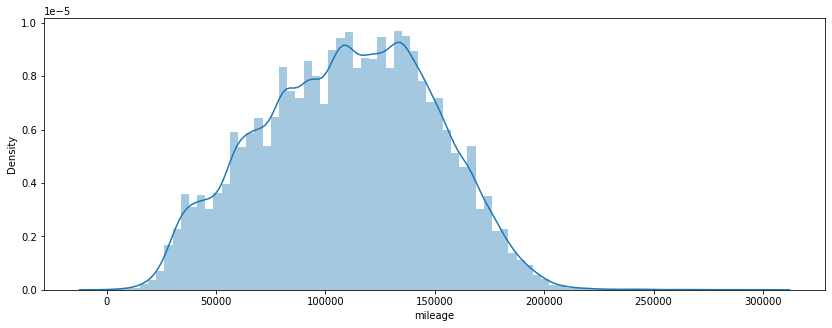

In [ ]:
plt.figure(figsize=(14,5))
sns.distplot(df_f['mileage'], bins=80);
plt.show()

* 카테고리 독립변수 확인
 * 'fuel', 'cylinders', 'transmission', 'drive', 'title_status'
 * 'paint_color', 'type' , 'title_status'
 * 'manufacturer', 'state', 

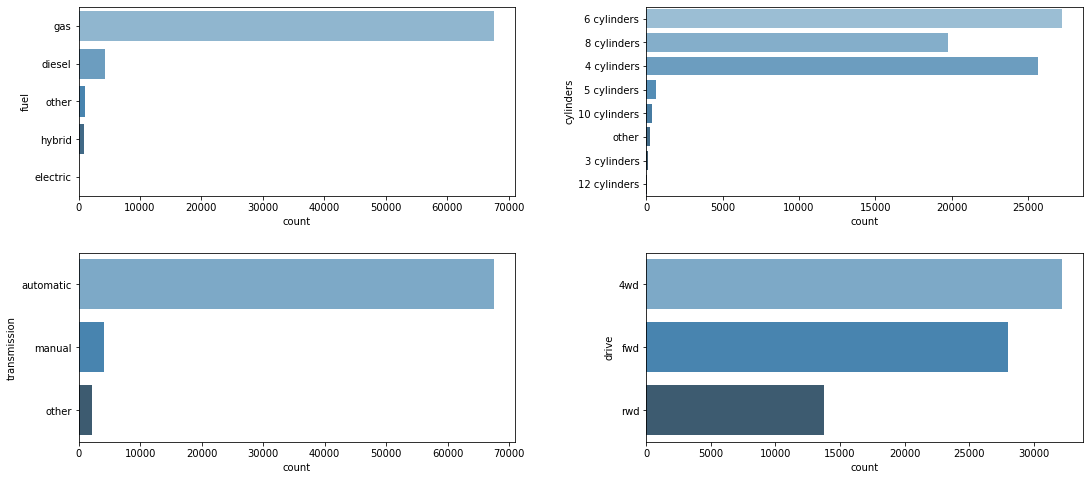

In [ ]:
match_list = ['fuel', 'cylinders', 'transmission', 'drive']

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 8))

for row in range(2) :
  for col in range(2) :
    idx = row * 2 + col
    m = match_list[idx]
    ax = axes[row][col]
    sns.countplot(data=df_f, y=m, ax=ax, palette="Blues_d", 
                  order = df[m].value_counts().index)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

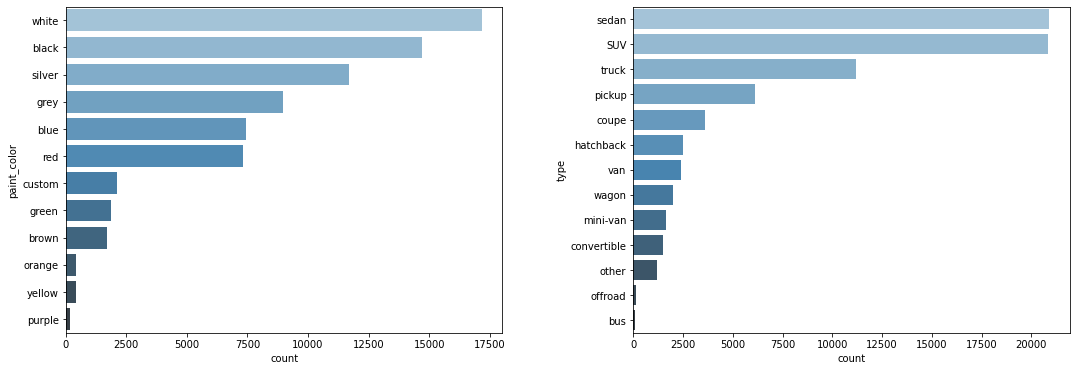

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(121)
sns.countplot(data=df_f, y='paint_color', palette="Blues_d",
              order = df_f['paint_color'].value_counts().index);

plt.subplot(122)
sns.countplot(data=df_f, y='type', palette="Blues_d",
              order = df_f['type'].value_counts().index);

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

* 변수 상관분석

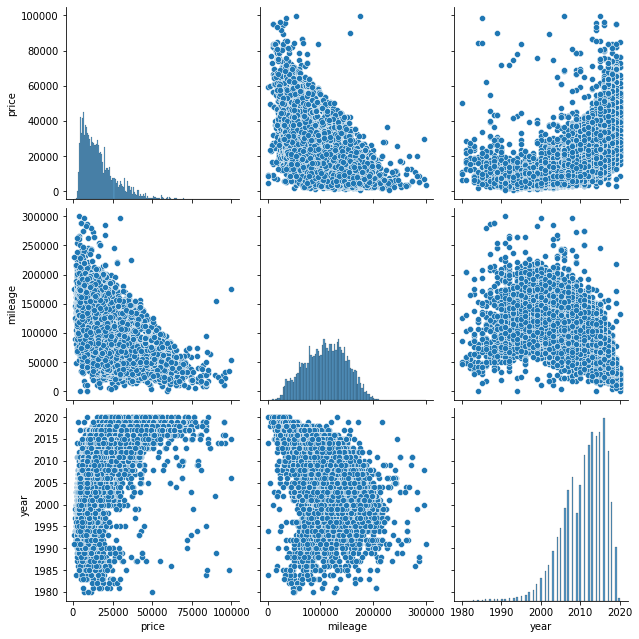

In [ ]:
sns.pairplot(df_f[['price','mileage','year']],size=3)
plt.show()

* 수치형 변수 상관관계 (회귀)
 * price, mileage
 * price, year

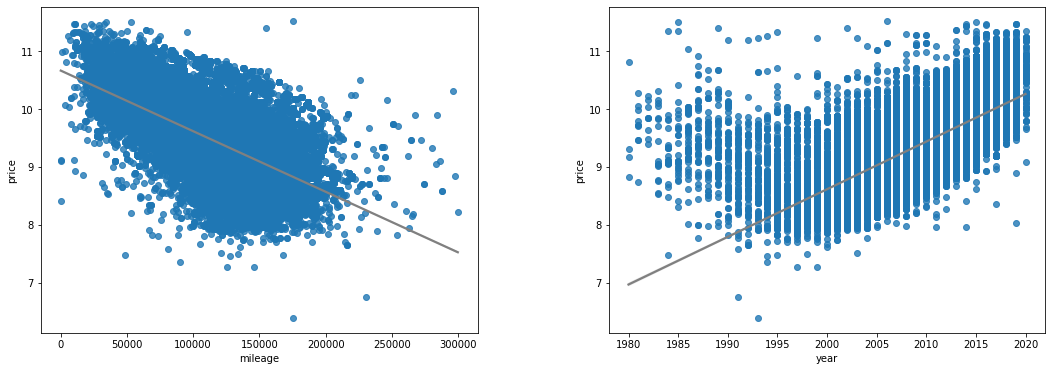

In [ ]:
plt.figure(figsize=(18,6))

plt.subplot(121)
sns.regplot(data=df_f, y= (np.log1p(df_f['price'])), x='mileage', line_kws={'color': 'gray'});

plt.subplot(122)
sns.regplot(data=df_f, y=(np.log1p(df_f['price'])), x='year', line_kws={'color': 'gray'});

plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.show()

#5. ML 모델링
* 다중선형회귀 모델을 사용하며, 사용 컬럼 갯수에 따라 R2 score의 차이(일부사용: 0.5, 전체사용: 0.7)가 커서 전체 데이터를 사용
* 이후 flask에서 app 구현시 필수데이터는 유저에게 입력받고, 다른 데이터는 기존 DB자료를 활용

In [ ]:
df = df_f.copy()

In [ ]:
X = df.drop(['price','vin','state', 'title_status',	'paint_color'], axis=1)
y = np.log1p(df['price'])

In [ ]:
trans_all = Pipeline([("encoder", OrdinalEncoder(cols=['model', 'manufacturer', 'fuel', 'cylinders',
                                                       'transmission', 'type', 'drive'])),                                             
                    # ("scaler", RobustScaler()),
                      ("imputer", SimpleImputer())])
scaled = trans_all.fit_transform(X)
X_enc = pd.DataFrame(scaled, index=X.index, columns=X.columns)
X_enc.head(2)

,model,manufacturer,year,mileage,fuel,cylinders,transmission,type,drive
0,1.0,1.0,2003.0,159041.0,1.0,1.0,1.0,1.0,1.0
1,2.0,2.0,1998.0,174381.0,1.0,2.0,1.0,2.0,2.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_enc, y, random_state=66, train_size=0.7, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51770, 9), (22188, 9), (51770,), (22188,))

기준 모델

In [ ]:
# price 평균값으로 예측 (기준모델)
predict = y_train.mean()
y_pred = [predict] * len(y_train)

# 회귀방정식 평가지표 (train)
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_train, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,0.426039
1,MAE,0.538630
2,RMSE,0.652717
3,R2,0.000000


전체 데이터 사용, 다중선형회귀 모델 사용

In [ ]:
model_all = LinearRegression()
model_all.fit(X_train, y_train)
y_pred = model_all.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_train, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,0.124160
1,MAE,0.265203
2,RMSE,0.352364
3,R2,0.708571


In [ ]:
#인코딩 내역 확인
#trans_all.named_steps

입력 받고 싶은 주요 컬럼만 사용했을 때

In [ ]:
X2 = df[['model', 'manufacturer', 'year', 'mileage']]

In [ ]:
trans = Pipeline([("encoder", OrdinalEncoder(cols=['model', 'manufacturer'])),
                  # ("scaler", RobustScaler()),
                   ("imputer", SimpleImputer())])
scaled2 = trans.fit_transform(X2)
X2_enc = pd.DataFrame(scaled2, index=X2.index, columns=X2.columns)
X2_enc.head(2)

,model,manufacturer,year,mileage
0,1.0,1.0,2003.0,159041.0
1,2.0,2.0,1998.0,174381.0


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X2_enc, y, random_state=66, train_size=0.7, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((51770, 4), (22188, 4), (51770,), (22188,))

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_train)

mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_train, y_pred)

display(pd.DataFrame([['MSE', mse],['MAE', mae],['RMSE', rmse],['R2', r2]], columns=['Metric', 'Score']))

,Metric,Score
0,MSE,0.202486
1,MAE,0.367924
2,RMSE,0.449984
3,R2,0.524725
